<a href="https://colab.research.google.com/github/Technology-for-the-Poorest-Billion/2025-Majicom-WaterCooling-passive/blob/main/GM2MajicomPassive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The aim of this script is to model the Majicom Kiosk as well as our small scale model, with the aim of validating the experimental methods and to provide further insight into the behaviour of the full scale model. More specifically, this model will provide:



1.   A means of estimating water temperature of the tank
2.   A comparison of how fabric properties affect cooling and drying rates
3.   An analysis of how air temperature and humidity affect evaporative cooling
4.   A method of modelling how long the fabric takes to fully dry



# **Setup**

---


This section will define the core classes, functions and elements to be used throughout this script, alongside an explanation of how they all function

Initialise this to import required libraries

In [ ]:
!pip install CoolProp
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import CoolProp.CoolProp as CP
from CoolProp.HumidAirProp import HAPropsSI
import scipy
from scipy.constants import sigma

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 71.1 MB/s eta 0:00:00


The following set of classes are the core input parameters to the code. They are designed to optimise flexibility and allow for easy input changes. The classes are constructed as follows


---

Air Properties (AP):





Understanding air property is vital to modelling the system accurately, particularly in humid environments where the properties may vary quite significantly. The properties of air are defined primarily by the temperature (Dry Bulb Temperature) and the relative humidity.

Additionally, pressure is a factor, although it has been assumed to be equal to atmospheric if unspecified. From these properties the "CoolProp" python library is used to deduce core properties such as density, viscosity and conductivity. Additionally, a simple empirical model is being used to calculate diffusion coefficients.

---

Fan Specification (fanSpec):



The behaviour of the fan is only governed by its CFD (cubic feet per minute) which is its volume flow rate and can be found in most specifications for fans. Additionally, its power draw is included to allow for some energy consumption estimation.

---

Tank Geometry (tankGeo):



This governs how the airflow from the fan relates to the air speed. Additionally it is a crucial set of parameters that determines the surface area covered by the fabric and the volume of water stored in the tank.

---

Material (mat):

The final input is the material itself. The material is defined by a wide range of properties that broadly speaking can be divided into its physical properties (density, porosity and layer thickness) and its thermal properties (thermal conductivity). Between these two categories as well as understanding how effectively the material soaks up water (msat, the mass of water absorbed per kg of fabric), the material behaviour can be fully understood.




In [ ]:
class AP: # Air Property
  def __init__(self,T,R, P = 101325):
    self.T = T # Temperature
    self.R = R # Relative Humidity
    self.P = P # Pressure

  def density(self):
    Vha = HAPropsSI('Vha', 'T', self.T, 'P', self.P, 'R', self.R)
    return 1/Vha

  def dynamicViscosity(self):
    return HAPropsSI('mu', 'T', self.T, 'P', self.P, 'R', self.R)

  def kinematicViscosity(self):
    return self.dynamicViscosity()/self.density()

  def thermalConductivity(self):
    return HAPropsSI('k', 'T', self.T, 'P', self.P, 'R', self.R)

  def diffusionCoefficient(self):
    A = -0.2989
    B = 1.6253e-3
    C = 7.5e-7

    D = A + B*self.T + C*(self.T)**2
    return D


class fanSpec: # fan properties
  def __init__(self,P, CFM, mode = "single"):
    self.P = P # Power Consumption
    self.CFM = CFM # Mass flow rate (Cubic Feet per minute)
    self.mode = mode # Fan mode (single from top or dual from side)


class tankGeo:
  def __init__(self,Router,Rinner,tankHeight,t, k):
    self.Router = Router # Kiosk Shell Radius
    self.Rinner = Rinner # Tank Radius
    self.tankHeight = tankHeight
    self.t = t # Wall thickness
    self.k = k # Thermal Conductivity of wall material

  def areaFlow(self):
    return np.pi*(self.Router**2) - np.pi*(self.Rinner**2)

  def volumeTank(self):
    return np.pi*(self.Rinner**2)*self.tankHeight

  def areaFlow(self):
    return np.pi*(self.Router**2) - np.pi*(self.Rinner**2)

  def areaTank(self):
    return 2*np.pi*(self.Rinner)*self.tankHeight

class mat: # material

  def __init__(self,k,t,msat,density,porosity, em = 0.87):
    self.k = k # Thermal Conductivity when dry
    self.t = t # Thickness
    self.msat = msat # Mass of water at maximum saturation per unit mass of material
    self.density = density # Density of material (dry)
    self.porosity = porosity # Porosity of material (fraction of the total volume that is empty pores)
    self.em = em # Emissivity of the fabric










# **Core Modelling**
---
Here all of the core modelling elements are produced. There are 6 key functions that are used to describe the kiosk apparatus






Air Velocity (velocityAir):

Uses the geometry of the tank and the properties of the fan to determine the air speed over the tank. Currently there are two built in operating modes, for cross flow and axial flow.



In [ ]:

def velocityAir(tank: tankGeo ,fan: fanSpec):


  if fan.mode == "single":
    A = tank.areaFlow()
  else:
    A = (tank.Router-tank.Rinner)*tank.tankHeight # May be off x2



  Q = fan.CFM*0.00047194745                           # Unit conversion between Cubic Feet per Minute and m^3/s
  v = Q/A


  return v







Mass Transfer Coefficient (hm):

This function utilises information about the transfer properties of air and the fan velocity to determine the mass transfer coefficient. This is used to determine the rate of surface evaporation.

In [ ]:
def hm(tank: tankGeo, fan:fanSpec, air:AP):               # Defining the mass transfer coefficient for water into humid air

  L = tank.tankHeight

  v = velocityAir(tank,fan)
  Sc = air.kinematicViscosity()/air.diffusionCoefficient() # Schmidt Number


  if fan.mode == "single":
   Re = (v*L)/air.kinematicViscosity()     # Reynold's Number with tank height as characteristic length
  else:
    Re = (v*2*tank.Rinner)/air.kinematicViscosity()  # Reynold's Number with diameter as characteristic length


  if fan.mode == "single" and Re <= 30000:
    Sh = 0.664*(Re**0.5)*(Sc**(1/3))

  elif fan.mode == "single" and Re> 30000:
    Sh = 0.036*(Re**0.8)*(Sc**(1/3))

  else:
     Sh = 0.61*(Re**0.5)*(Sc**(1/3))

  return Sh*air.diffusionCoefficient()/L

Energy Balance Calculator (evaporationEnergy):

This function provides a range of output data by considering an energy balance, modelling the system as an RC network (using a resistive analogy for heat transfer). This function takes the fabric temperature (Tf) and the water temeprature (Tw) as inputs and uses this information to determine mass loss rates, and a error term (e) which is the excess power flowing into the fabric for this set of conditions.

In [ ]:
def evaporationEnergy(tank: tankGeo, fan:fanSpec, material: mat, air: AP, S, Tf,Tw ): # New Variable S is the mass saturation = mass of water / maximum mass of water

  massCoeff = hm(tank,fan,air)

  A = tank.areaTank()
  densityWater = 1000 # kg/m^3






  ## Finding Thermal conductivity of the material


  VTotal = tank.areaTank()*material.t
  massMaterial = (1-material.porosity)*VTotal*material.density # total mass of fibres
  massWaterMax = material.msat*massMaterial
  VWater = S*massWaterMax/densityWater # Total volume of water added
  VPore = material.porosity*VTotal # Volume of pores
  VMaterial = VTotal - VPore

  kWater = 0.6 #estimate for thermal conductivity of water
  hAir = 10    # convective heat loss coefficient for air (may need to change)
  hfg = 2260e3 # Latent heat of evaporation
  kAir = HAPropsSI('k', 'T', air.T, 'P', air.P, 'R', air.R)


  kMaterial = (material.k - material.porosity*air.thermalConductivity())/(1- material.porosity) # Assuming that the given conductivity is of the dry weave (so includes some amount of air). This roughly solves for conductivity of fibre alone


  ## Handling 3 Phase mixture conductivity

  if VPore > VWater: # Not all pores in the fibre are occupied so there is still some air remaining

    VAir = VPore - VWater
    kTotal = (kMaterial*VMaterial + kWater*VWater + air.thermalConductivity()*VAir)/VTotal

  else: # The pores in the fibre are fully occupied with water and all air is displaced. Additional water can be absorbed by swelling

    kTotal = (kMaterial*VMaterial + kWater*VWater)/VTotal



  ## Finding convective coefficients

  L = tank.tankHeight

  v = velocityAir(tank,fan)
  if fan.mode == "single":
   Re = (v*L)/air.kinematicViscosity()     # Reynold's Number with tank height as characteristic length
  else:
    Re = (v*2*tank.Rinner)/air.kinematicViscosity()  # Reynold's Number with diameter as characteristic length



  cp = HAPropsSI('C', 'T', air.T, 'P', air.P, 'R', air.R)
  Pr = cp*air.dynamicViscosity()/(air.thermalConductivity())

  if fan.mode == "single" and Re <= 30000:
    Nu = 0.664*(Re**0.5)*(Pr**(1/3))
    hAir = Nu*kAir/L

  elif fan.mode == "single" and Re> 30000:
    Nu = 0.036*(Re**0.8)*(Pr**(1/3))
    hAir = Nu*kAir/L

  else:
     Nu = 0.61*(Re**0.5)*(Pr**(1/3))
     hAir = Nu*kAir/(2*tank.Rinner)







  ## Defining the thermal resistances based on thermal conductivity


  Raf = 1/(hAir*A) #Thermal resistance from air to fabric
  Rfw = np.log((tank.Rinner + material.t) / tank.Rinner)/(2*np.pi*tank.tankHeight*kTotal) + np.log((tank.Rinner) / (tank.Rinner - tank.t) )/(2*np.pi*tank.tankHeight*tank.k) #Thermal resistance from fabric to water. Currently to surface of water
  Raw = tank.t/(tank.k*2*np.pi*(tank.Rinner**2))




  ## Emmisivity calculations

  emKiosk = 0.92 #Based on emissivity of white fibreglass CONFIRM THIS
  AKiosk = 2*np.pi*tank.Router*tank.tankHeight
  RKiosk = (1-emKiosk)/(emKiosk*AKiosk)
  RShape = 1/AKiosk
  RTank = (1-material.em)/(material.em*A)
  EbKiosk = sigma*(air.T**4)
  EbTank = sigma*(Tf**4)
  RRad = RKiosk + RShape + RTank
  qrad = (EbKiosk - EbTank)/(RRad)



  ## Evaluating energy balance


  Pv =  HAPropsSI('P_w', 'T', Tf, 'P', air.P, 'R', 1)
  Ps = HAPropsSI('P_w', 'T', air.T, 'P', air.P, 'R', air.R)
  mdot = S*massCoeff*A*(Pv - Ps)

  q_evap = mdot*hfg

  qaf = (air.T - Tf)/Raf
  qwf = (Tw - Tf)/Rfw

  e = qaf + qwf - q_evap + qrad # error

  return [e,mdot,Rfw]

Fabric Temperature (tempFabric):

This function uses the error term from evaporationEnergy and iteratively tests for different values of Tf using a Newton-Raphson scheme. The aim is to determine the value of Fabric Temperature that allows for balanced energy flow in and out of the fabric (determining where e = 0) for a given Water Temperature

In [ ]:
def fabricTemp(tank: tankGeo, fan:fanSpec, material: mat, air: AP, S,Tw):

  tol = 1e-3
  delta = 0.1
  Tf = air.T
  maxRunTime = 100

  for i in range (maxRunTime):


    e0 = evaporationEnergy(tank,fan,material,air,S,Tf,Tw)[0]
    e1 = evaporationEnergy(tank,fan,material,air,S,Tf + delta,Tw)[0]
    de = (e1 - e0)/delta
    Tf2 = Tf - e0/de


    if abs(e0) < tol:
      break
    else:
      Tf = Tf2



  return Tf

Determining Water Temperature (simulateTemp):

This function uses the prior two functions to determine the temperature of the water as the system evolves from a set of initial conditions. It uses a numerical differentiation scheme to model the energy draw through the capacitor, returning a time series temperature development and a "stable temperature" at which variation is below a defined threshold.

This function has two operating modes: "constant" where it is assumed that water is added to the fabric at the same rate it is dried, and "drying" where the water starts at a known saturation and is allowed to dry as the water cools

In [ ]:
def simulateTemp(tank: tankGeo, fan:fanSpec, material: mat, air: AP, S,Twinit, tmax = 86400, dt = 300, mode = 'constant'):

    tol = 0.0001

    Smat = S

    densityWater = 1000
    c = 4186
    V = tank.volumeTank()
    Cw = densityWater*c*V

    timeSeries = [0]
    TwSeries = [Twinit]
    t = 0
    while timeSeries[-1] < tmax:
      Tw = TwSeries[-1]
      Tf = fabricTemp(tank,fan,material,air,Smat,Tw)
      Rfw = evaporationEnergy(tank,fan,material,air,Smat,Tf,Tw)[2]
      qfw = (Tf - Tw)/Rfw
      Raw = tank.t/(tank.k*2*np.pi*(tank.Rinner**2))
      qaw = (air.T - Tw)/Raw

      dT = qfw *dt/Cw #YK
      Twnew = Tw + dT
      t += dt
      timeSeries.append(t)
      TwSeries.append(Twnew)





      if abs(float(Twnew - Tw)) < tol:
         break

      if mode == 'drying':

          V = tank.areaTank()*material.t
          mMaterial = (1-material.porosity)*V*material.density
          mWaterSat = material.msat*mMaterial
          mWater = mWaterSat*Smat

          mdotEvap = evaporationEnergy(tank,fan,material,air,Smat, Tf,Tw)[1]
          dm = mdotEvap*dt
          mWater -= dm
          Smat = mWater/mWaterSat

      if Smat <= 0:
        Smat = 0


    return [TwSeries[-1],timeSeries,TwSeries]


Rate of fabric drying (coolingRate):

This function determines how the saturation of the fabric varies as time progresses and can be used to determine how often the fabric needs to be resoaked in order to maintain consistent performance

In [ ]:
def coolingTime(tank: tankGeo , fan:fanSpec, material: mat, air: AP, Twinit, Sinit, Sfinal, dt = 300):

  V = tank.areaTank()*material.t
  mMaterial = (1-material.porosity)*V*material.density
  mWaterSat = material.msat*mMaterial


  massCoeff = hm(tank,fan,air)


  # Initialise
  S = Sinit # S = current water mass / maximum water mass
  minit = Sinit*mWaterSat
  mfinal = Sfinal*mWaterSat
  mWater = minit
  time = 0
  Tw = Twinit

  # Drying loop

  while mWater > mfinal:
    Tw = simulateTemp(tank,fan,material,air,S, Tw , tmax = dt, dt = dt, mode = 'drying')[0]
    Tf = fabricTemp(tank,fan,material,air,S,Tw)
    mdotEvap = evaporationEnergy(tank,fan,material,air,S, Tf,Tw)[1]
    dm = mdotEvap*dt
    mWater -= dm
    S = mWater/mWaterSat



    time += dt
    if mWater < mfinal:

      mWater = mfinal


  return time/60






Attempting to run functions with an initial starting point

# **Input Database**
---

Material Database:

The next step is to produce a database of material properties that we are considering. This will contain a range of material properties for different materials that are of interest

In [ ]:
cotton = mat(0.045, 0.002, 3.5, 1540, 0.7)
linen = mat(0.04, 0.002, 2.25, 1500, 0.65 )
jute = mat(0.03,0.002, 2.75, 1450, 0.6)
materialTest = mat(0.9, 0.001, 2.5 ,400,0.7)

Fan Models:

The model of fan will have a notable effect on the rate of cooling. It will affect air speed and power consumption. Below are a range of fans that are being considered for this application.

In [ ]:
fanModelSingle = fanSpec(1,130) #PV123812DSPF 01
fanModelDual = fanSpec(1,130, "dual")
fanReal = fanSpec(1,500)

Tank Geometries:

A collection of different tank geometries


In [ ]:
tankModel = tankGeo(0.07,0.04,0.09,0.001, 0.5)
tankReal = tankGeo(0.54,0.45,0.8,0.04,0.49)

Air Properties:

Different air properties defined to characterise regions or conditions of interest


In [ ]:
#UK Modelling conditions
airModel = AP(293, 0.6)

#Tanzanian Real world conditions
tempAvg = 273.15 + 33
airReal = AP(tempAvg, 0.7)

# **Tests & Results**
---

**Temperatature and Humidity Variation:**

This test will explore how temperature and humidity of the surrounding air will affect the quality of cooling in the tank.

There are two main aims with this test. Firstly, it is to identify how the temperature will vary with seasonality. The marked test is for the wet season where the humidity is slightly higher and the air is a bit cooler. During the dry season it tends to be hotter and less humid.

Additionally, it is of interest to see whether using dryer hotter air is more effective than using cooler moist air. This will inform future design and determine whether it is worth dehumidifying air as it enters the tank or using air that has passed through an active cooling system.

The graph contains constant temperature contours which act as efficiency frontiers for dehumidification. Any methodology that crosses these contours downwards provides an effective means of increasing cooling.

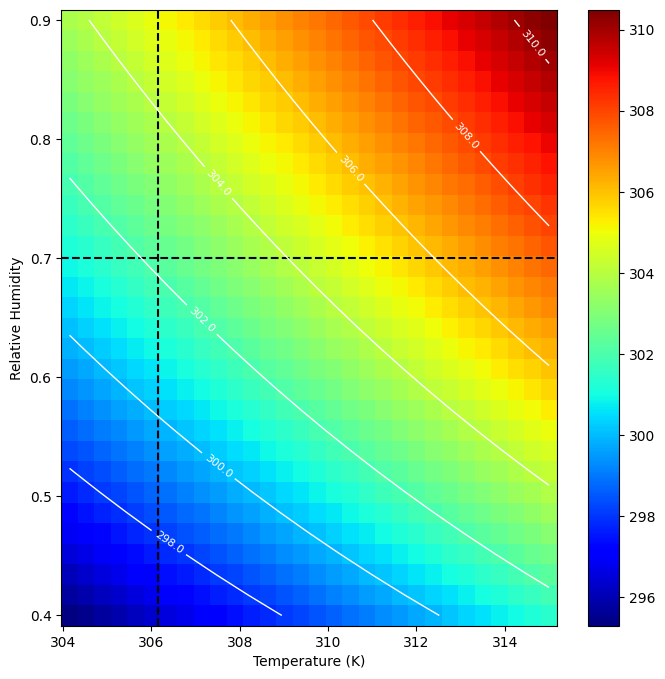

In [ ]:
tank = tankReal
material = cotton
fan = fanReal


Trange = np.linspace(tempAvg-2,315,30)
Rrange = np.linspace(0.4,0.9,30)
TwMatrix = np.zeros((len(Rrange), len(Trange)))
S = 0.5

for i, R in enumerate(Rrange):
  for j, T in enumerate(Trange):
    air = AP(T,R)
    TwMatrix[i,j] = simulateTemp(tank,fan,material,air,S, tempAvg, dt = 1800)[0]





plt.figure(figsize=(8,8))
X,Y = np.meshgrid(Trange,Rrange)
c = plt.pcolormesh(X,Y,TwMatrix, cmap='jet')
plt.colorbar(c)

plt.axvline(x = tempAvg, color = 'black', linestyle = '--')
plt.axhline(y = 0.7, color = 'black', linestyle = '--')


tempIntersect = simulateTemp(tank,fan,material,AP(tempAvg,0.7),S, tempAvg, dt = 1800)[0]

levels = np.arange(298, 316, 2)

if not any(np.isclose(levels, tempIntersect, atol=0.5)):
      levels = np.sort(np.append(levels, tempIntersect)) # Ensure frontier temp included

contours = plt.contour(X, Y, TwMatrix, levels=levels, colors='white', linewidths=1)
plt.clabel(contours, inline=True, fontsize=8, fmt='%1.1f')

plt.xlabel('Temperature (K)')
plt.ylabel('Relative Humidity')

plt.show()




Constant Saturation vs Drying:

The below test demonstrates the deviation between the fabric when it is run at a constant saturation (i.e it is continuously resoaked) or when it is allowed to dry.

The two main takeaways are to firstly identify when they begin to deviate (so that an optimal resaturation point can be identified) and also to determine the consequences of the fabric fully drying regarding the reheating of the cool water

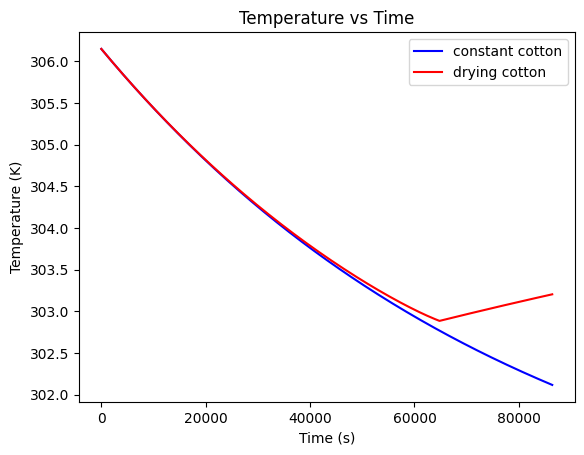

In [ ]:
constantResults = simulateTemp(tankReal, fanReal, cotton, airReal, 1, tempAvg)
dryingResults = simulateTemp(tankReal, fanReal, cotton, airReal, 1, tempAvg, mode = 'drying')



plt.plot(constantResults[1], constantResults[2], color = 'blue', label = 'constant cotton')
plt.plot(dryingResults[1], dryingResults[2], color = 'red', label = 'drying cotton')

plt.title('Temperature vs Time for different drying modes')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.show()





Material Comparison:

This segment will attempt to model the variation in behaviour between the three different materials tested. The aim here is to determine an initial preference for a material choice. Additionally these results can be compared to experimental data to analyse how closely the model aligns with real world results

<function matplotlib.pyplot.show(close=None, block=None)>

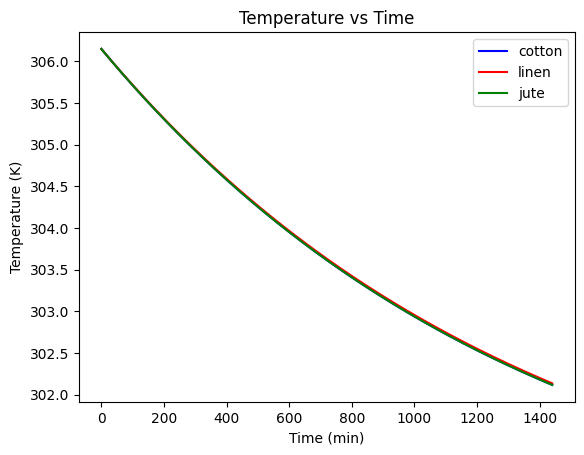

In [ ]:
cottonResults = simulateTemp(tankReal, fanReal, cotton, airReal, 1, tempAvg)
linenResults = simulateTemp(tankReal, fanReal, linen, airReal, 1, tempAvg)
juteResults = simulateTemp(tankReal, fanReal, jute, airReal, 1, tempAvg)
cottonTime = [x/60 for x in cottonResults[1]]
linenTime = [x/60 for x in linenResults[1]]
juteTime = [x/60 for x in juteResults[1]]

plt.plot(cottonTime, cottonResults[2], color = 'blue', label = 'cotton')
plt.plot(linenTime, linenResults[2], color = 'red', label = 'linen')
plt.plot(juteTime, juteResults[2], color = 'green', label = 'jute')
plt.title('Temperature vs Time for varying material')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.show




Fan Characteristics:

The next two studies will explore how the two fan configurations differ to one another. Specifically this is looking at how cooling time varies with saturtion and atmospheric humidity. Both the single fan and dual fan mode are plotted based on the conditions used for the experimental prototype in order to see how they differ under varying conditions

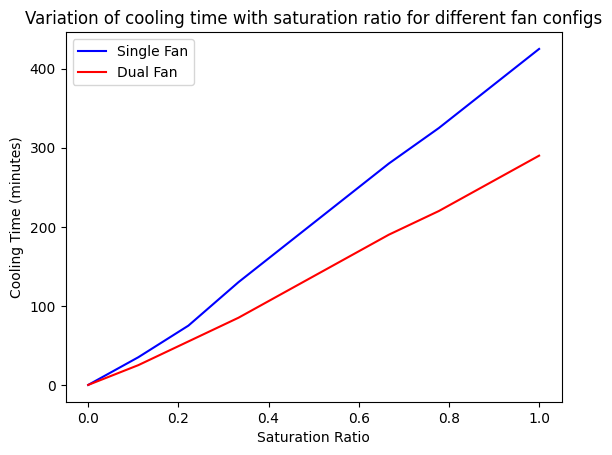

In [ ]:

S = np.linspace(0,1,10)
timeSingle = np.zeros(len(S))
timeDual = np.zeros(len(S))
for i, s in enumerate(S):
  timeSingle[i] = coolingTime(tankModel,fanModelSingle,cotton,airReal, tempAvg, s, 0, dt = 300 )
  timeDual[i] = coolingTime(tankModel,fanModelDual,cotton,airReal, tempAvg, s,0, dt = 300)
de = 'drying'
plt.xlabel('Saturation Ratio')
plt.ylabel('Cooling Time (minutes)')
plt.title('Variation of cooling time with saturation ratio for different fan configs')
plt.plot(S,timeSingle, color = 'blue', label = 'Single Fan')
plt.plot(S,timeDual, color = 'red', label = 'Dual Fan')
plt.legend()
plt.show()
plt.show()

Currently the numbers from this seem to large. In order to test this, I will compare these results with the experimental work done. Experimental data will provide: saturated mass and mass loss within a specific period of time. For the air conditions in lab and the geometry of the apparatus, I can estimate and compare cooling time to reach a specific saturation ratio

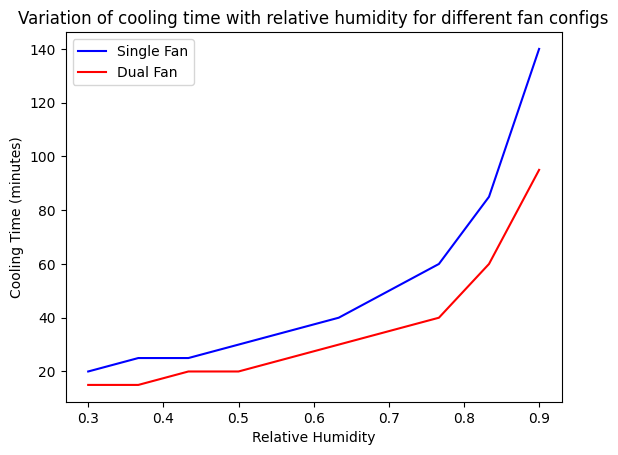

In [ ]:
R = np.linspace(0.3,0.9,10)
timeSingle = np.zeros(len(R))
timeDual = np.zeros(len(R))

for i, r in enumerate(R):
  air = AP(tempAvg,r)
  timeSingle[i] = coolingTime(tankModel,fanModelSingle,materialTest,air,1,0, dt = 300)
  timeDual[i] = coolingTime(tankModel,fanModelDual,materialTest,air,1,0, dt = 300)


plt.xlabel('Relative Humidity')
plt.ylabel('Cooling Time (minutes)')
plt.title('Variation of cooling time with relative humidity for different fan configs')
plt.plot(R,timeSingle, color = 'blue', label = 'Single Fan')
plt.plot(R,timeDual, color = 'red', label = 'Dual Fan')
plt.legend()
plt.show()

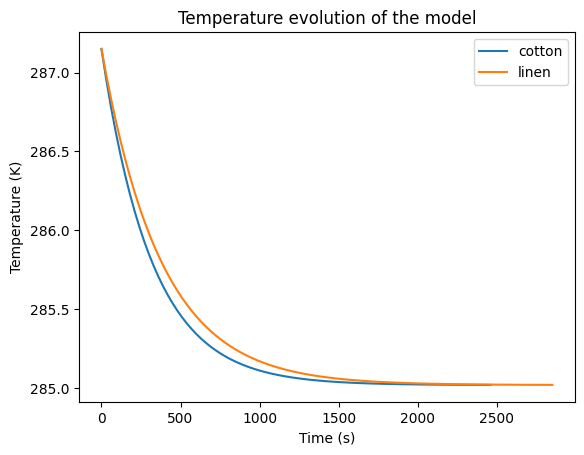

In [ ]:

testCotton = simulateTemp(tankModel, fanModelSingle, cotton, airModel, 1, 273.15 + 14, dt = 30 )
testLinen = simulateTemp(tankModel, fanModelSingle, linen, airModel, 1, 273.15 + 14, dt = 30 )
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)')
plt.title('Temperature evolution of the model')
plt.plot(testCotton[1],testCotton[2], label = "cotton")
plt.plot(testLinen[1], testLinen[2], label = "linen")
plt.legend()
plt.show()
